In [34]:
import cv2
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")


def get_perspective(img, location, height = 900, width = 900):
    location = sorted([(x, y) for x, y in location[:, 0, :]])
    if location[1][1] > location[0][1]:
        pts1 = np.float32([location[0], location[2], location[1], location[3]])
    else:
        pts1 = np.float32([location[1], location[3], location[0], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result


def split_boxes(board):
    rows = np.array_split(board, 9, axis=0)
    boxes = []
    for r in rows:
        cols = np.array_split(r, 9, axis=1)
        for box in cols:
            boxes.append(box)
    return boxes


class compute_hog(object):
    def __init__(self, cell_size, block_size, nbins):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins

    def __call__(self, img):
        img = np.array(img)
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // self.cell_size[1] * self.cell_size[1],
                                          img.shape[0] // self.cell_size[0] * self.cell_size[0]),
                                _blockSize=(self.block_size[1] * self.cell_size[1],
                                            self.block_size[0] * self.cell_size[0]),
                                _blockStride=(self.cell_size[1], self.cell_size[0]),
                                _cellSize=(self.cell_size[1], self.cell_size[0]),
                                _nbins=self.nbins)
        return torch.tensor(hog.compute(img.astype(np.uint8)).flatten().astype(np.float32))


def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_loader, test_loader, model, epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, test_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, \
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if val_acc > best_acc:
                print('BOINK')
                best_acc = val_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)

    return model, history


def predict(img, model):
    if img.sum() < 100000:
        return -1
    f = compute_hog((4,4), (3,3), 9)
    img = f(cv2.resize(img, (28, 28)))
    model.eval()
    outputs = model(torch.tensor(img)[None, ...])
    probs = nn.functional.softmax(outputs, dim=-1).detach().numpy()
    return np.argmax(probs)


def predict_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)

    # Filter out all numbers and noise to isolate only boxes
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    max_area = 0
    big_square = []
    for c in cnts:
        area = cv2.contourArea(c)
        max_area = max(max_area, area)

    for c in cnts:
        area = cv2.contourArea(c)
        if area < max_area:
            cv2.drawContours(thresh, [c], -1, (0, 0, 0), -1)
        else:
            big_square = [c]
            location = cv2.approxPolyDP(c, 1000, True)

    mask = np.zeros(thresh.shape)
    cv2.drawContours(mask, big_square, -1, (1, 1, 1), -1)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

    table = get_perspective(cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5) - thresh, location)

    kernel =  cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    kernel_2 =  cv2.getStructuringElement(cv2.MORPH_RECT,(2, 2))
    table = cv2.morphologyEx(table, cv2.MORPH_OPEN, kernel, iterations=1)
    table = cv2.morphologyEx(table, cv2.MORPH_OPEN, kernel_2, iterations=4)
    plot_img(table)
    boxes = split_boxes(table)

    ans = []
    for i in range(9):
        row = []
        for j in range(9):
            row += [predict(boxes[9 * i + j], model_1)]
        ans += [row]

    return mask, [ans]


batch_size_train = 64
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    compute_hog((4, 4), (3, 3), 9)
                                ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    compute_hog((4, 4), (3, 3), 9)
                                ])),
    batch_size=batch_size_test, shuffle=True)

model = nn.Sequential(
    nn.Linear(2025, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model_1, history = train(train_loader, test_loader, model=model, epochs=5)

epoch:   0%|                                                                                                                                                                                                                                              | 0/5 [00:00<?, ?it/s]

loss 0.12024843717962504


epoch:  20%|██████████████████████████████████████████████                                                                                                                                                                                        | 1/5 [00:06<00:25,  6.31s/it]


Epoch 001 train_loss: 0.1202     val_loss 0.0512 train_acc 0.9655 val_acc 0.9837
BOINK
loss 0.04542125884387642


epoch:  40%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 2/5 [00:12<00:18,  6.22s/it]


Epoch 002 train_loss: 0.0454     val_loss 0.0493 train_acc 0.9856 val_acc 0.9832
loss 0.03168057645040875


epoch:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 3/5 [00:18<00:12,  6.27s/it]


Epoch 003 train_loss: 0.0317     val_loss 0.0328 train_acc 0.9900 val_acc 0.9885
BOINK
loss 0.023723706928927762


epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4/5 [00:25<00:06,  6.29s/it]


Epoch 004 train_loss: 0.0237     val_loss 0.0397 train_acc 0.9925 val_acc 0.9873
loss 0.02004378414514164


epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.31s/it]


Epoch 005 train_loss: 0.0200     val_loss 0.0298 train_acc 0.9936 val_acc 0.9904
BOINK


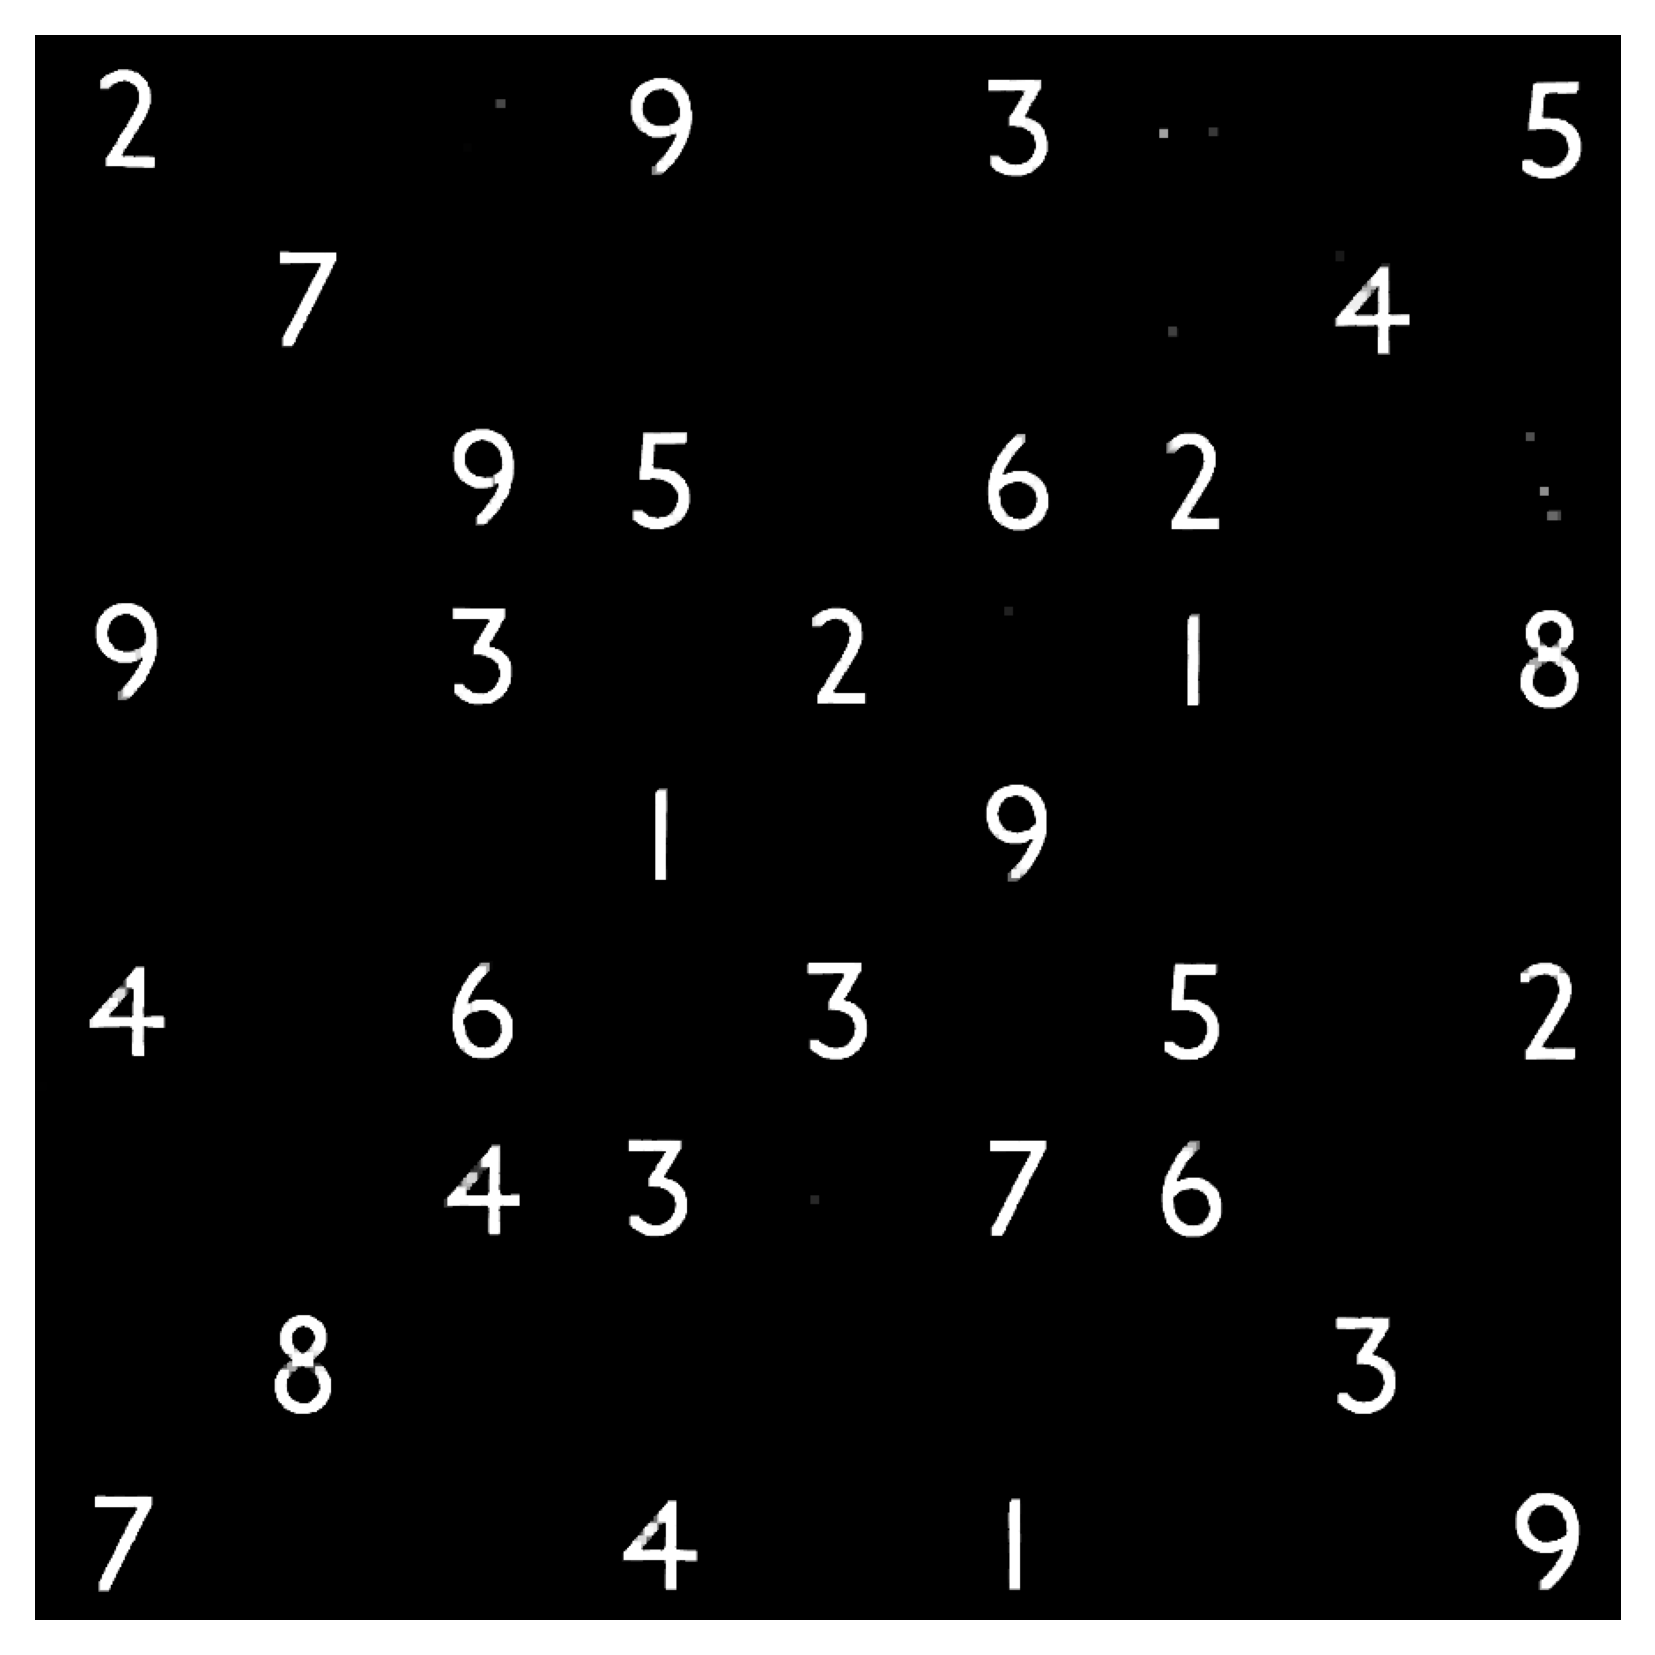

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [[[2, -1, -1, 9, -1, 3, -1, -1, 5],
   [-1, 7, -1, -1, -1, -1, -1, 4, -1],
   [-1, -1, 9, 5, -1, 6, 2, -1, -1],
   [9, -1, 3, -1, 2, -1, -1, -1, 8],
   [-1, -1, -1, -1, -1, 9, -1, -1, -1],
   [4, -1, 6, -1, 3, -1, 5, -1, 2],
   [-1, -1, 4, 3, -1, 7, 6, -1, -1],
   [-1, 8, -1, -1, -1, -1, -1, 3, -1],
   [7, -1, -1, 4, -1, -1, -1, -1, 9]]])

In [32]:
predict_image(cv2.imread('train/train_3.jpg'))

In [43]:
!python3 evaluate.py

/Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
epoch:   0%|                                              | 0/5 [00:00<?, ?it/s]loss 0.10502871995555858
                                                                                
Epoch 001 train_loss: 0.1050     val_loss 0.0463 train_acc 0.9688 val_acc 0.9843
epoch:  20%|███████▌                              | 1/5 [00:11<00:44, 11.10s/it]BOINK
loss 0.04437382328895231
                                                                                


DIGIT SCORE [[[4, -1, -1, 5, -1, 7, -1, -1, 6], [-1, 5, -1, -1, 6, -1, -1, 3, -1], [-1, -1, -1, 2, -1, 1, -1, -1, -1], [5, -1, 1, 9, 8, 6, 7, -1, 4], [-1, 8, -1, 4, -1, 3, -1, 6, -1], [6, -1, 4, 7, 1, 2, 8, -1, 3], [-1, -1, -1, 1, -1, 5, -1, -1, -1], [-1, 4, -1, -1, 7, -1, -1, 1, -1], [8, -1, -1, 3, -1, 4, -1, -1, 7]]] [[[4, -1, -1, 5, -1, 7, -1, -1, 6], [-1, 5, -1, -1, 6, -1, -1, 3, -1], [-1, -1, -1, 2, -1, 1, -1, -1, -1], [5, -1, 1, 9, 8, 6, 7, -1, 4], [-1, 8, -1, 4, -1, 3, -1, 6, -1], [6, -1, 4, 7, 1, 2, 8, -1, 3], [-1, -1, -1, 1, -1, 5, -1, -1, -1], [-1, 4, -1, -1, 7, -1, -1, 1, -1], [8, -1, -1, 3, -1, 4, -1, -1, 7]]]
Raw IoU score = 1.00
Raw digit recognition score = 1.00
Prediction time = 0.24s. Evaluation overhead = 0.19s.

### Summary ###
Final train score (finding tables) = 45.00 out of 45.00
Final train score (recognizing digits) = 37.28 out of 45.00
Total evaluation time = 7.94s for 9 images.
The platform limit is 2400s for 30 images.


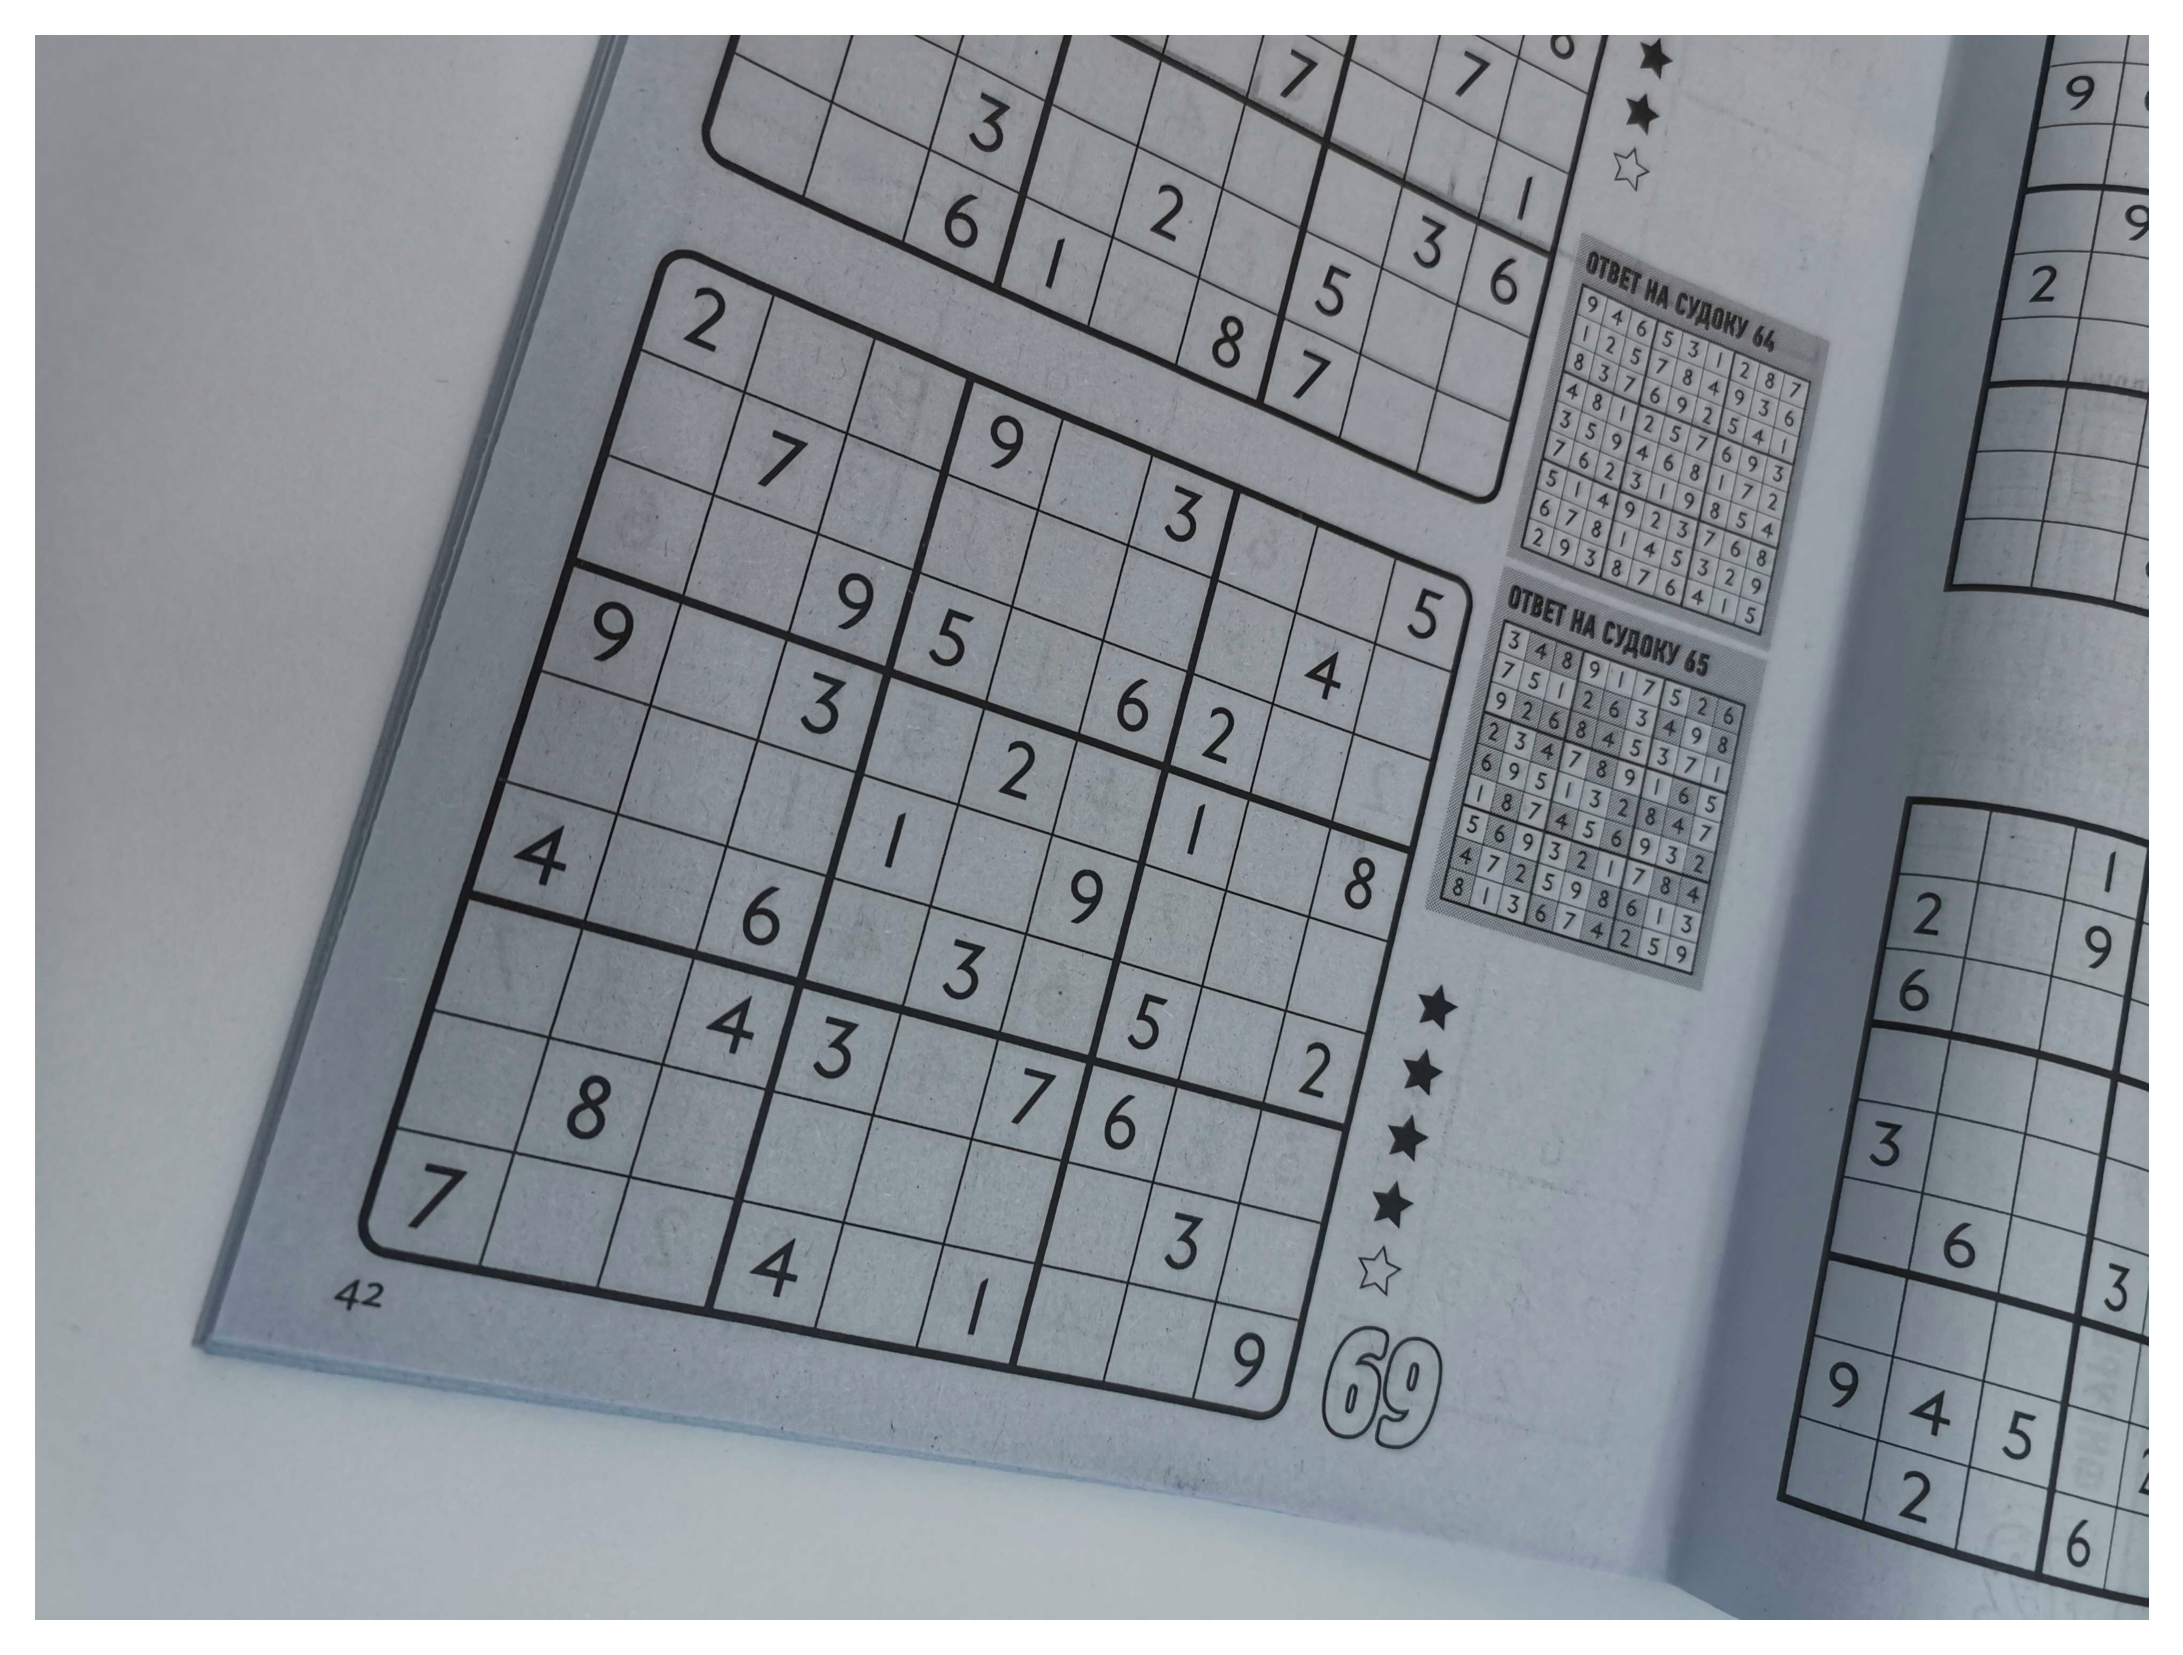

In [25]:
plot_img(cv2.imread('train/train_3.jpg'))